In [7]:
from AL import *
from passive_model_perf import *
from update_combined_data import *
#from eval_adaptability import *
from compare_ATL_strategies import *
from analyze_target_tree_growth import *

import numpy as np
import joblib
import copy
from tqdm.notebook import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

sources = ["amides", "sulfonamides", "ROH"]
targets = ["heterocycles", "alkyl amines", "anilines"]
num_desired_rxns = [8,3,2]

In [2]:
### Import arrays
source_desc = joblib.load('./array_joblibs/source_desc_dict.joblib')
target_desc = joblib.load('./array_joblibs/target_desc_dict.joblib')
source_y = joblib.load('./array_joblibs/source_y_dict.joblib')
target_y = joblib.load('./array_joblibs/target_y_dict.joblib')
source_id = joblib.load('./array_joblibs/source_id_dict.joblib')
target_id = joblib.load('./array_joblibs/target_id_dict.joblib')

### Instantiate arrays
amide_desc, amide_y = source_desc["amides"], source_y["amides"]
sulfon_desc, sulfon_y = source_desc["sulfonamides"], source_y["sulfonamides"]
ROH_desc, ROH_y = source_desc["ROH"], source_y["ROH"]
source_desc = [amide_desc, sulfon_desc, ROH_desc]
source_y = [amide_y, sulfon_y, ROH_y]

het_desc, het_y, het_id = target_desc["heterocycles"], target_y["heterocycles"], target_id["heterocycles"]
alkyl_desc, alkyl_y, alkyl_id = target_desc["alkyl amines"], target_y["alkyl amines"], target_id["alkyl amines"]
anil_desc, anil_y, anil_id = target_desc["anilines"], target_y["anilines"], target_id["anilines"]

In [3]:
### Training 25 source models of 5 trees of depth 1
### for amide, sulfonamide, ROH

all_source_models = []
for i, source in enumerate(sources):
    model_list = prepare_models(source_desc[i], source_y[i], 25)
    all_source_models.append(model_list)

# Easy scenarios (N-nucs --> aniline/alkyl amine)

100%|██████████| 25/25 [00:00<00:00, 302.01it/s]


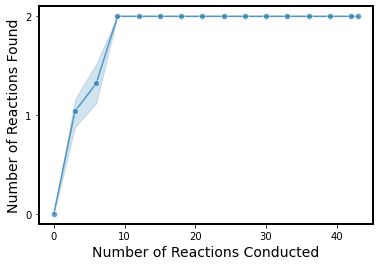

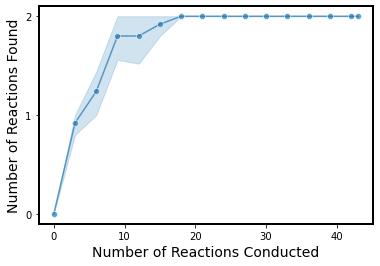

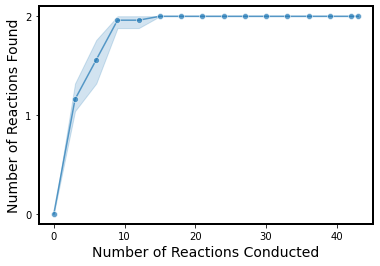

In [4]:
anil_perf_dict = passive_for_anil_or_alkyl(
    sources, all_source_models, source_desc, source_y,
    anil_desc, anil_id, anil_y, "aniline"
)

### Figures S11~13 left column
plot_passive_perfs(anil_perf_dict, sources, "aniline", 2)

100%|██████████| 25/25 [00:00<00:00, 274.27it/s]


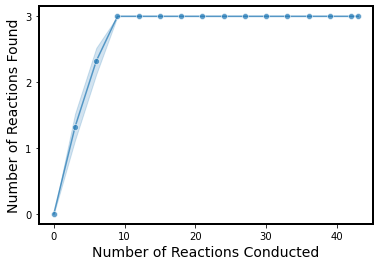

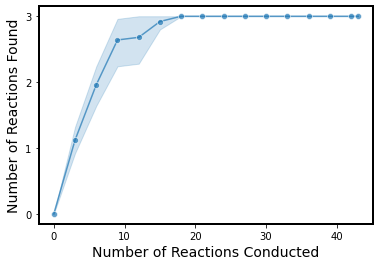

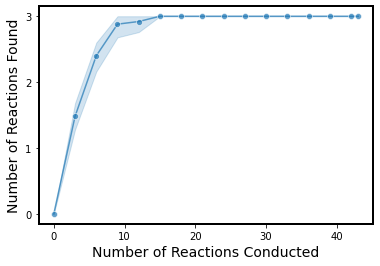

In [5]:
alkyl_perf_dict = passive_for_anil_or_alkyl(
    sources, all_source_models, source_desc, source_y,
    alkyl_desc, alkyl_id, alkyl_y, "alkyl amine"
)

### Figures S11~13 right column
plot_passive_perfs(alkyl_perf_dict, sources, "alkyl amine", 3)

# N-nucs -> pyrazole

In [4]:
nnucs_to_pyrazole_ATL_perf, nnucs_to_pyrazole_models = compare_ATL_strategies(
    sources, all_source_models, source_desc, source_y,
    het_desc, het_id, het_y
)

100%|██████████| 3/3 [00:18<00:00,  6.28s/it]


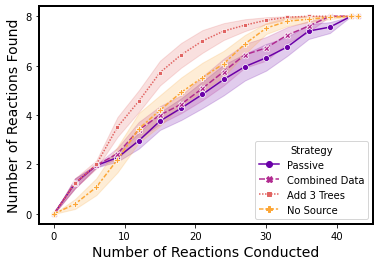

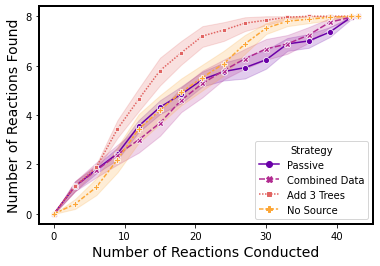

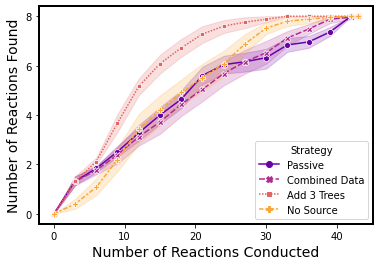

In [9]:
### Figures 5A, S14 top row
plot_ATL_perf_comparison(
    sources, nnucs_to_pyrazole_ATL_perf
)

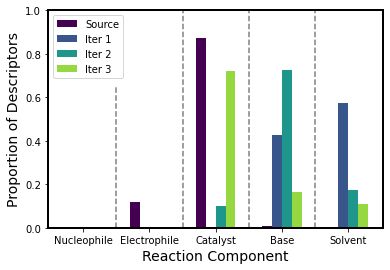

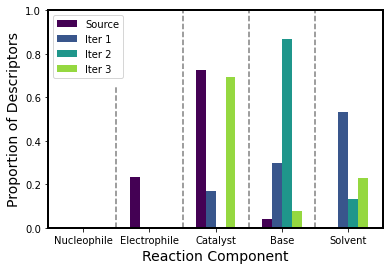

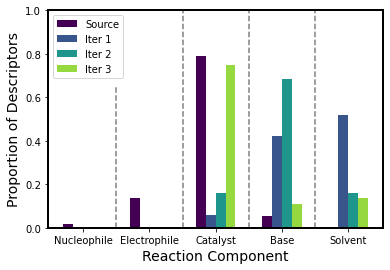

In [10]:
### Which descriptors are used by models at different iterations
### Figures 5B, S14 bottom row 
for i,source in enumerate(sources) : 
    source_portion, batch1_portion,\
    batch2_portion, batch3_portion = get_component_portion_per_batch(
        source, nnucs_to_pyrazole_models, 
        num_weights_considered=4, weight_idx=2
    )
    plot_component_portions(source_portion, batch1_portion, batch2_portion, batch3_portion)

In [5]:
### Move to analyze_target_tree_growth.py after settled

def new_plot_conducted_rxns_by_pca(list_of_selected_rxns_per_batch,
                               target_id, target_desc,
                               xmin=-4, xmax=7, ymin=-5, ymax=8,
                               filename=None):
    ''' For a single model instance, plots on a PCA plot of which reactions
    were selected every iteration up to the fifth batch.
    Desired reactions are marked with * and opposite with x.'''
    ### PCA Transformation
    scaler = StandardScaler()
    # not necessary to transform nuc, elec
    target_std = scaler.fit_transform(target_desc[:, 33:])
    pca = PCA(n_components=40)
    target_pca = pca.fit_transform(target_std)[:, :2]
    ### Data Jittering to avoid overlap of points
    for i, id_row in enumerate(target_id):
        if id_row[3] == 2:
            target_pca[i, 1] += 0.6
        elif id_row[3]==1:
            target_pca[i,1]+= 0.08
        elif id_row[3] == 4:
            target_pca[i, 1] -= 0.44
        elif id_row[3] == 3:
            target_pca[i, 1] += 0.1
    eigen_vals = pca.singular_values_
    ### Plot of all target rxns
    fig, ax = plt.subplots()
    ax.set_aspect(eigen_vals[1]/eigen_vals[0])
    sel_idx = []
    color_dict = {0:"#0b1b82", 1:"#ea9454"}
    ### Collecting conducted rxns each batch
    for i, (rxns_desc, rxns_id, rxns_y) in enumerate(list_of_selected_rxns_per_batch):
        if i < 5:
            for j, rxn in enumerate(rxns_desc):
                ind = np.where(np.all(rxn == target_desc, axis=1))[0][0]
                sel_idx.append(ind)
                ax.annotate(s=i+1, xy=(target_pca[ind, 0], target_pca[ind, 1]),
                            xytext=(target_pca[ind, 0], target_pca[ind, 1]),
                            c=color_dict[rxns_y[j]], ha="center", va="center",
                           fontweight="semibold")
    unsel_idx = [x for x in range(target_pca.shape[0]) if x not in sel_idx]
    ax.scatter(x=target_pca[unsel_idx, 0],
               y=target_pca[unsel_idx, 1], c='grey', s=30, alpha=0.4)
    
    marker_legend_elements = [
        Line2D([0], [0], markerfacecolor="grey", marker='o',
               color="w", label="Unlabeled", markersize=10, alpha=0.4),
        Line2D([0], [0], color="#0b1b82", label="Positive", linewidth=2),
        Line2D([0], [0], color="#ea9454", label="Negative", linewidth=2),
    ]
    marker_legend = ax.legend(handles=marker_legend_elements,
                              bbox_to_anchor=(1, 1), title="Reaction Label")
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_xticks([-4, -2, 0, 2, 4, 6])
    ax.set_xticklabels([-4, -2, 0, 2, 4, 6])
    ax.set_xlabel("PC1 (Catalyst)", fontsize=14)
    ax.set_ylabel("PC2 (Solvent, Base)", fontsize=14)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    if filename is not None:
        fig.savefig(f"./figures/figure8D_{filename}.pdf",
                    format="pdf", dpi=300, bbox_inches="tight")

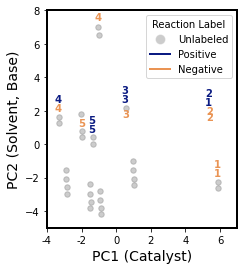

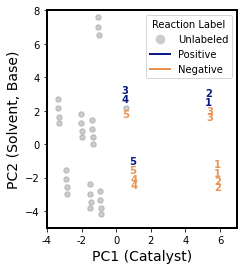

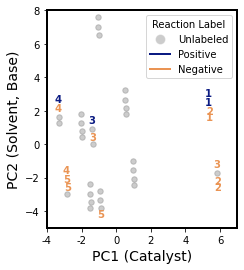

In [6]:
# ATL
new_plot_conducted_rxns_by_pca(nnucs_to_pyrazole_models["amides_to_heterocycle"]["arrays"][6], het_id, het_desc)
# Passive
new_plot_conducted_rxns_by_pca(nnucs_to_pyrazole_models["amides_to_heterocycle"]["arrays"][20], het_id, het_desc)
# Combined
new_plot_conducted_rxns_by_pca(nnucs_to_pyrazole_models["amides_to_heterocycle"]["arrays"][1], het_id, het_desc)

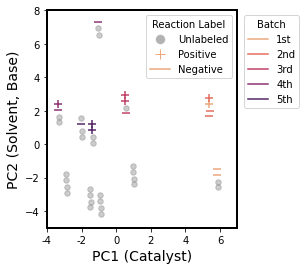

In [5]:
pal = sns.color_palette("flare", 29) #crest
plot_conducted_rxns_by_pca(nnucs_to_pyrazole_models["amides_to_heterocycle"]["arrays"][6], het_id, het_desc,
                           marker_dict={1:"_",0:"+"},
                          color_list=[x for i, x in enumerate(pal.as_hex()) if i%7 == 0])

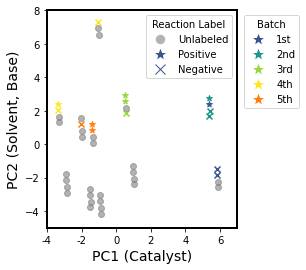

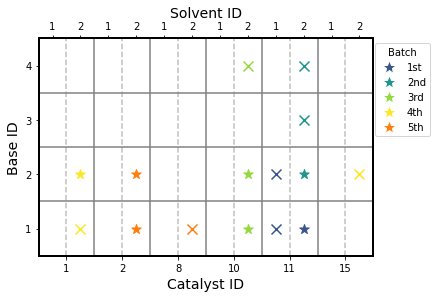

In [5]:
### Which reactions are selected by target tree growth
### Figures 5C and 6
plot_conducted_rxns_by_pca(nnucs_to_pyrazole_models["amides_to_heterocycle"]["arrays"][6], het_id, het_desc,
                          filename="FixedGrey")
plot_conducted_rxns_by_comp_ids(nnucs_to_pyrazole_models["amides_to_heterocycle"]["arrays"][6])

### Evaluating adaptability of two ATL strategies

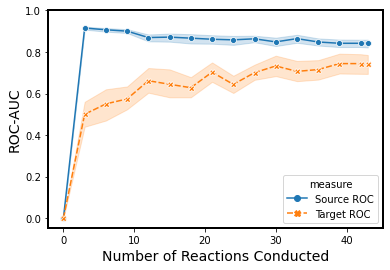

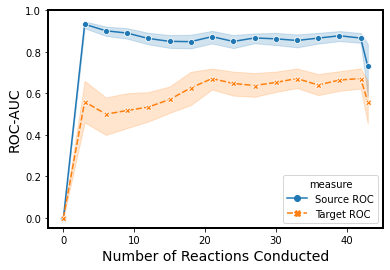

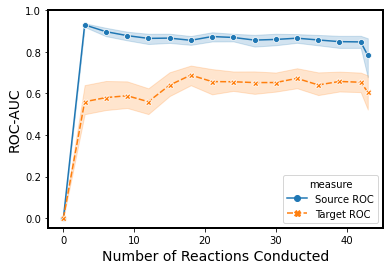

In [10]:
### Figure S15A - Train on combined data
for i, source in enumerate(sources):
    for j in tqdm(range(25)):
        roc_source_rxns, roc_collected_rxns,\
        prob_desired_rxns  = get_roc_and_probs_by_batch(nnucs_to_pyrazole_models, source, j, 1,
                                                        source_desc[i], source_y[i],
                                                        num_weights_considered=4)    
        if j==0 : dict_to_plot1, dict_to_plot2 = None, None
        else : 
            dict_to_plot1 = AL_and_ROC
        AL_and_ROC = prep_dict_to_plot_AL_and_ROC(nnucs_to_pyrazole_ATL_perf, source, j, 1, 
                                                  roc_source_rxns,
                                                  roc_collected_rxns,
                                                  num_weights_considered=4,
                                                  dict_to_plot=dict_to_plot1)
      
    plot_AL_and_ROC(AL_and_ROC, "ROC-AUC",  None, ci=95)

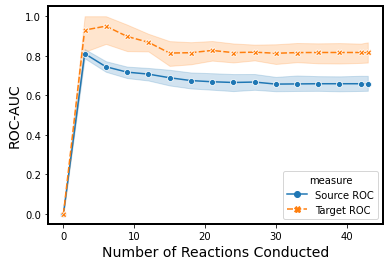

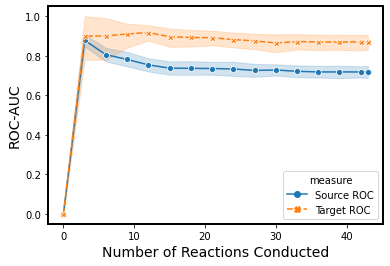

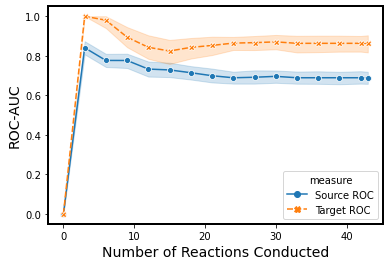

In [11]:
### Figure S15B - Target tree growth
for i, source in enumerate(sources):
    for j in tqdm(range(25)):
        roc_source_rxns, roc_collected_rxns,\
        prob_desired_rxns  = get_roc_and_probs_by_batch(nnucs_to_pyrazole_models, source, j, 2,
                                                        source_desc[i], source_y[i],
                                                        num_weights_considered=4)    
        if j==0 : dict_to_plot1, dict_to_plot2 = None, None
        else : 
            dict_to_plot1 = AL_and_ROC
        AL_and_ROC = prep_dict_to_plot_AL_and_ROC(nnucs_to_pyrazole_ATL_perf, source, j, 2, 
                                                  roc_source_rxns,
                                                  roc_collected_rxns,
                                                  num_weights_considered=4,
                                                  dict_to_plot=dict_to_plot1)
      
    plot_AL_and_ROC(AL_and_ROC, "ROC-AUC",  None, ci=95)

### Evaluating importance weights for re-training on combined data

In [12]:
for i, source in enumerate(sources):
    if i==0 :
        perf_dict = None
        model_dict = None
    perf_dict, model_dict=compare_weights(
                source, all_source_models[i], [0,1,3,5],
                source_desc[i], source_y[i], het_desc, het_id, het_y, 
                len(het_y)-sum(het_y), 
                "new", perf_dict=perf_dict, model_dict=model_dict)

100%|██████████| 25/25 [00:06<00:00,  3.82it/s]


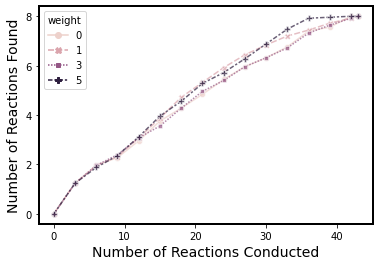

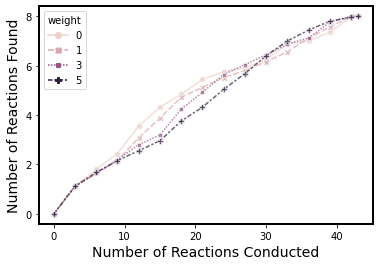

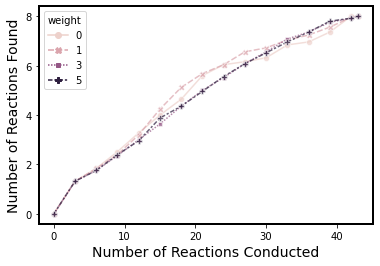

In [13]:
### Figure S16
for i,source in enumerate(sources) :
    plot_AL_performance_by_weight(source, perf_dict, filename=None)

### Evaluating the number of target trees

  4%|▍         | 1/25 [00:00<00:03,  6.64it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


  8%|▊         | 2/25 [00:00<00:03,  6.22it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 12%|█▏        | 3/25 [00:00<00:03,  6.26it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 20%|██        | 5/25 [00:00<00:03,  5.92it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 24%|██▍       | 6/25 [00:01<00:03,  5.86it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 32%|███▏      | 8/25 [00:01<00:02,  5.67it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 36%|███▌      | 9/25 [00:01<00:03,  4.43it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 44%|████▍     | 11/25 [00:02<00:03,  4.37it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 48%|████▊     | 12/25 [00:02<00:03,  4.21it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 56%|█████▌    | 14/25 [00:02<00:02,  4.74it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 60%|██████    | 15/25 [00:03<00:02,  4.79it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 68%|██████▊   | 17/25 [00:03<00:01,  5.37it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 72%|███████▏  | 18/25 [00:03<00:01,  5.15it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 76%|███████▌  | 19/25 [00:03<00:01,  5.84it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 84%|████████▍ | 21/25 [00:04<00:00,  5.50it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 88%|████████▊ | 22/25 [00:04<00:00,  5.16it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 92%|█████████▏| 23/25 [00:04<00:00,  5.25it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 96%|█████████▌| 24/25 [00:04<00:00,  5.62it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


  4%|▍         | 1/25 [00:00<00:03,  6.52it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


  8%|▊         | 2/25 [00:00<00:03,  6.36it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 16%|█▌        | 4/25 [00:00<00:03,  5.74it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 20%|██        | 5/25 [00:00<00:03,  6.09it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 24%|██▍       | 6/25 [00:01<00:03,  6.25it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 32%|███▏      | 8/25 [00:01<00:02,  5.78it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 36%|███▌      | 9/25 [00:01<00:02,  5.43it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 40%|████      | 10/25 [00:01<00:02,  5.07it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 44%|████▍     | 11/25 [00:02<00:02,  5.18it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 48%|████▊     | 12/25 [00:02<00:02,  5.10it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 52%|█████▏    | 13/25 [00:02<00:02,  4.80it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 56%|█████▌    | 14/25 [00:02<00:02,  4.75it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 64%|██████▍   | 16/25 [00:03<00:01,  5.35it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 68%|██████▊   | 17/25 [00:03<00:01,  5.62it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 76%|███████▌  | 19/25 [00:03<00:01,  4.87it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 80%|████████  | 20/25 [00:03<00:00,  5.29it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 84%|████████▍ | 21/25 [00:03<00:00,  5.51it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 92%|█████████▏| 23/25 [00:04<00:00,  5.27it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 96%|█████████▌| 24/25 [00:04<00:00,  5.28it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


  0%|          | 0/25 [00:00<?, ?it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


  4%|▍         | 1/25 [00:00<00:04,  5.45it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 12%|█▏        | 3/25 [00:00<00:03,  5.98it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 16%|█▌        | 4/25 [00:00<00:03,  5.71it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 24%|██▍       | 6/25 [00:01<00:03,  5.77it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 28%|██▊       | 7/25 [00:01<00:03,  5.77it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 32%|███▏      | 8/25 [00:01<00:03,  5.65it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 40%|████      | 10/25 [00:01<00:02,  6.05it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 44%|████▍     | 11/25 [00:01<00:02,  6.40it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 52%|█████▏    | 13/25 [00:02<00:01,  6.10it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 56%|█████▌    | 14/25 [00:02<00:01,  6.10it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 60%|██████    | 15/25 [00:02<00:01,  5.64it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 68%|██████▊   | 17/25 [00:02<00:01,  6.24it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 72%|███████▏  | 18/25 [00:02<00:01,  6.30it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 80%|████████  | 20/25 [00:03<00:00,  6.47it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 84%|████████▍ | 21/25 [00:03<00:00,  6.77it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 92%|█████████▏| 23/25 [00:03<00:00,  6.17it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


 96%|█████████▌| 24/25 [00:03<00:00,  5.94it/s]

        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees
        Starting with 5 Trees


100%|██████████| 25/25 [00:04<00:00,  5.96it/s]

        Starting with 5 Trees


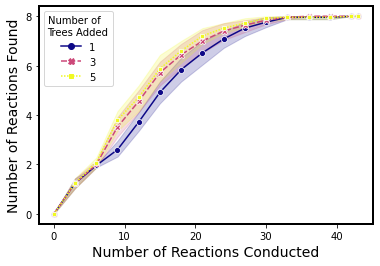

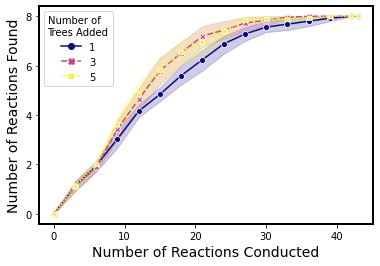

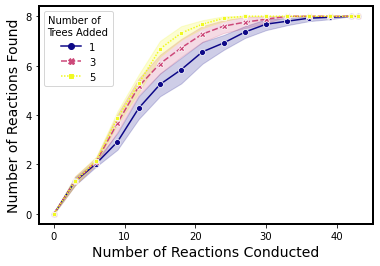

In [15]:
### Figure S17
perf_by_num_trees_added = compare_num_trees(
    sources, all_source_models, source_desc, source_y,
    het_desc, het_id, het_y
)

plot_ATL_perf_comparison(sources, perf_by_num_trees_added,
                        "Number of\nTrees Added",
                        "Number of\nTrees Added")

### Evaluating other reaction selection strategies

100%|██████████| 3/3 [00:30<00:00, 10.24s/it]


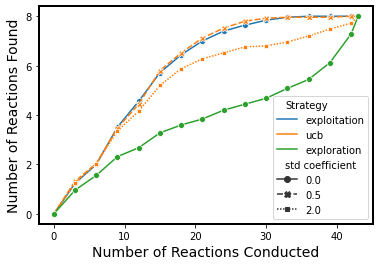

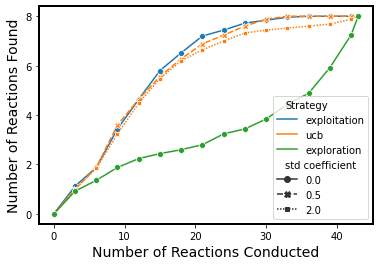

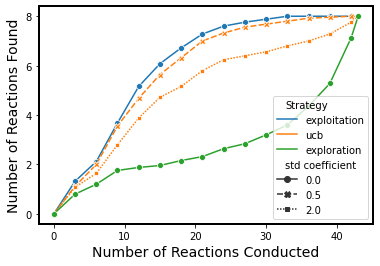

In [6]:
### Figure S18
perf_by_strategy = compare_strategies(
    sources, all_source_models, source_desc, source_y,
    het_desc, het_id, het_y
)
plot_ATL_perf_comparison(sources, perf_by_strategy,
                         "Strategy", "std coefficient", ci=None, 
                        palette=None)

### Evaluating source model complexity on target tree growth

100%|██████████| 3/3 [00:27<00:00,  9.33s/it]


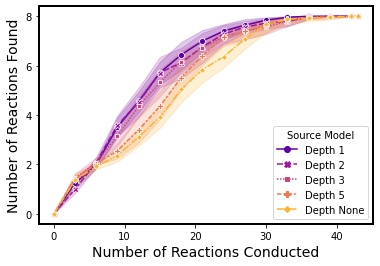

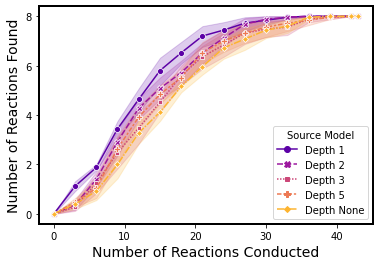

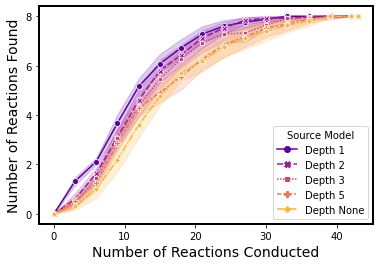

In [6]:
### Figures 7A, S19A and S19B
perf_by_depth = compare_source_model_hyperparam(
    sources, all_source_models, source_desc, source_y,
    het_desc, het_id, het_y,
    "depth", [1,2,3,5,None]
)
plot_ATL_perf_comparison(sources, perf_by_depth, 
                         "Source Model", "Source Model")

100%|██████████| 3/3 [01:04<00:00, 21.61s/it]


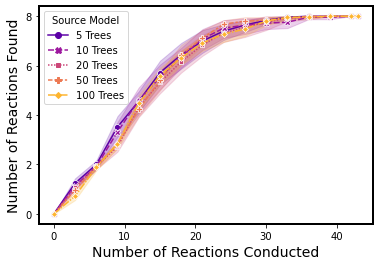

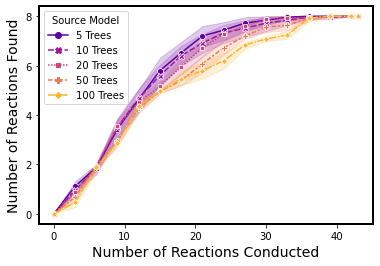

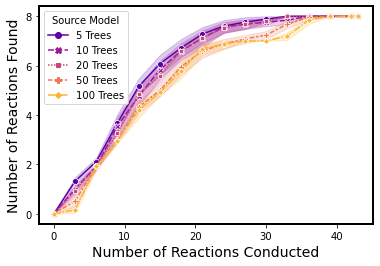

In [7]:
### Figures 7B, S19C and S19D
perf_by_ntrees = compare_source_model_hyperparam(
    sources, all_source_models, source_desc, source_y,
    het_desc, het_id, het_y,
    "num_trees", [5,10,20,50,100]
)
plot_ATL_perf_comparison(sources, perf_by_ntrees, 
                         "Source Model", "Source Model")

# Additional Example 1 (Figure S20)

In [4]:
pip_id = joblib.load("./array_joblibs/arrays_for_additional_ATL/pip_id.joblib")
pip_desc = joblib.load("./array_joblibs/arrays_for_additional_ATL/pip_desc.joblib")
pip_y = joblib.load("./array_joblibs/arrays_for_additional_ATL/pip_y.joblib")
pip_y[pip_y>0]=1

In [5]:
nnucs_to_pip_ATL_perf, nnucs_to_pip_models = compare_ATL_strategies(
    sources, all_source_models, source_desc, source_y,
    pip_desc, pip_id, pip_y
)

100%|██████████| 3/3 [00:24<00:00,  8.31s/it]


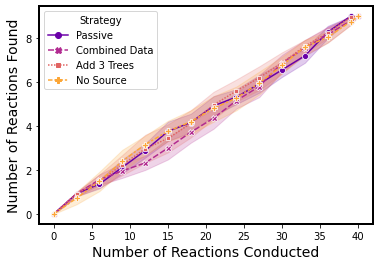

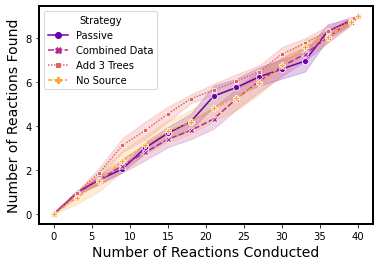

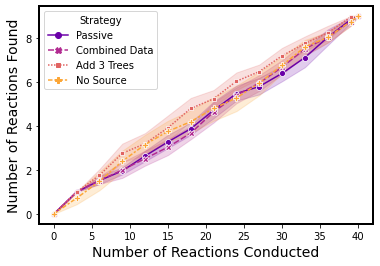

In [7]:
### Figures S20B~D
plot_ATL_perf_comparison(
    sources, nnucs_to_pip_ATL_perf
)

# Additional Example 2 (Figure S21)

In [165]:
malon_source_arrays = joblib.load("./array_joblibs/arrays_for_additional_ATL/malon_source_arrays.joblib")
indanone_arrays = joblib.load("./array_joblibs/arrays_for_additional_ATL/indanone_arrays_for_ATL.joblib")

In [166]:
malonate_models = prepare_models(
    malon_source_arrays[1], 
    1-malon_source_arrays[2], 25, 3, 1
)

In [167]:
malon_to_pip_ATL_perf, malon_to_pip_models = compare_ATL_strategies(
    ["malonate"], [malonate_models], 
    [malon_source_arrays[1]], [1-malon_source_arrays[2]],
    indanone_arrays[1], indanone_arrays[0], 1-indanone_arrays[2]
)

100%|██████████| 1/1 [00:06<00:00,  6.17s/it]


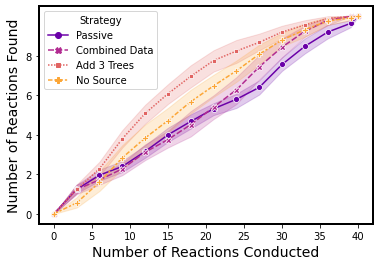

In [168]:
plot_ATL_perf_comparison(
    ["malonate"], malon_to_pip_ATL_perf
)

# Additional Example 3 (Figure S22)

In [176]:
pyBOH2_id = joblib.load("./array_joblibs/arrays_for_additional_ATL/pyBOH2_id.joblib")
pyBOH2_y = joblib.load("./array_joblibs/arrays_for_additional_ATL/pyBOH2_y.joblib")
pyBOH2_desc = joblib.load("./array_joblibs/arrays_for_additional_ATL/pyBOH2_desc.joblib")
pyBOH2_y[pyBOH2_y > 0] = 1

full_id_arrays_by_nuc = joblib.load("./array_joblibs/full_id_arrays_by_nuc.joblib")
full_desc_arrays_by_nuc = joblib.load("./array_joblibs/full_desc_arrays_by_nuc.joblib")
full_y_arrays_by_nuc = joblib.load("./array_joblibs/full_y_arrays_by_nuc.joblib")

Bpin_id = full_id_arrays_by_nuc["Bpin"]
Bpin_desc = full_desc_arrays_by_nuc["Bpin"]
Bpin_y = full_y_arrays_by_nuc["Bpin"]

# Remove catalysts 4, 7 and 11 reactions for electrophile 2
# to secure some number of 'new reagent combination' in target
# 4, 7 and 11 were chosen to make the problem as hard as possible
# (they give the most number of positive yields with elec 2)
overlap_cat_inds = list(np.where(np.all(Bpin_id[:,1:3]==[2,4], axis=1))[0]) +\
    list(np.where(np.all(Bpin_id[:,1:3]==[2,7], axis=1))[0]) +\
    list(np.where(np.all(Bpin_id[:,1:3]==[2,11], axis=1))[0])
inds = [x for x in range(Bpin_id.shape[0]) if x not in overlap_cat_inds]
Bpin_id = Bpin_id[inds]
Bpin_desc = Bpin_desc[inds]
Bpin_y = Bpin_y[inds]

In [162]:
Bpin_models = prepare_models(
    Bpin_desc, 1-Bpin_y, 25, 3
)

In [163]:
Bpin_to_BOH2_ATL_perf, Bpin_to_BOH2_models = compare_ATL_strategies(
    ["Bpin"], [Bpin_models], 
    [Bpin_desc], [1-Bpin_y],
    pyBOH2_desc, pyBOH2_id, 1-pyBOH2_y
)

100%|██████████| 1/1 [00:04<00:00,  4.58s/it]


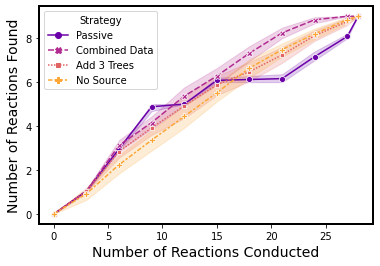

In [170]:
plot_ATL_perf_comparison(
    ["Bpin"], Bpin_to_BOH2_ATL_perf
)

# Preliminary results on combined source datasets

In [9]:
combined_source_models = []

combined_source_desc = [
    np.vstack((source_desc[0], source_desc[1])), #amide+sulfon
    np.vstack((source_desc[0], source_desc[2])), #amide+ROH
    np.vstack((source_desc[1], source_desc[2])), # sulfon +ROH
    np.vstack((source_desc[0], source_desc[1], source_desc[2])) #everything
]
combined_source_y = [
    np.concatenate((source_y[0], source_y[1])),
    np.concatenate((source_y[0], source_y[2])),
    np.concatenate((source_y[1], source_y[2])),
    np.concatenate((source_y[0], source_y[1], source_y[2]))
]
for i in range(4):
    combined_source_models.append(prepare_models(combined_source_desc[i], combined_source_y[i], 25))

In [10]:
comb_nnucs_to_pyrazole_ATL_perf, comb_nnucs_to_pyrazole_models = compare_ATL_strategies(
    ["amide+sulfon", "amide+ROH", "sulfon+ROH", "ALL"], combined_source_models, combined_source_desc, combined_source_y,
    het_desc, het_id, het_y
)

100%|██████████| 4/4 [00:27<00:00,  6.98s/it]


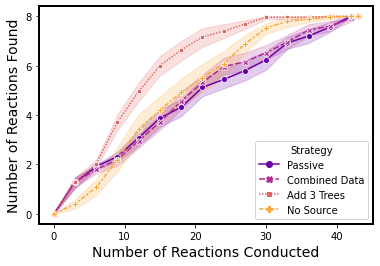

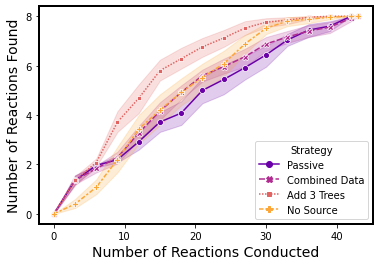

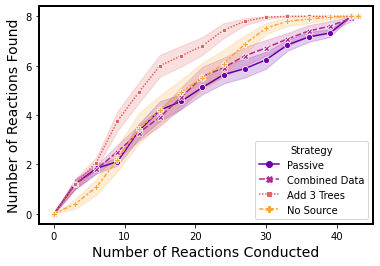

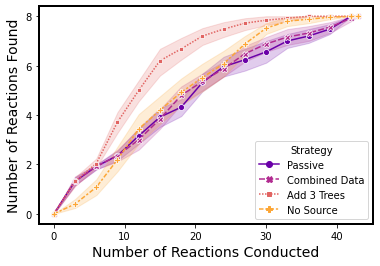

In [11]:
plot_ATL_perf_comparison(
    ["amide+sulfon", "amide+ROH", "sulfon+ROH", "ALL"], comb_nnucs_to_pyrazole_ATL_perf
)

# Analysis on source vs target reaction conditions

In [18]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Pipeline(steps=[('scaler', StandardScaler()),
                ('cluster', KMeans(n_clusters=3, random_state=42))])

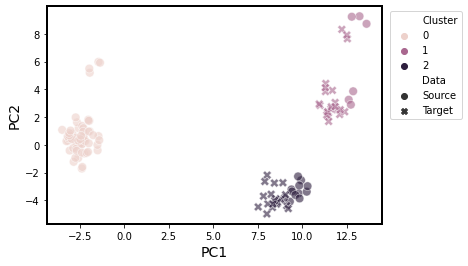

In [47]:
std = StandardScaler()
kmeans = KMeans(n_clusters=3, random_state=42)
pca = PCA(n_components=2)

std_source = std.fit_transform(source_desc[0][:, 6:])
std_het = std.transform(het_desc[:, 6:])
source_coord = pca.fit_transform(std_source)
target_coord = pca.transform(std_het)
source_cluster = kmeans.fit(std_source)
target_cluster = kmeans.predict(std_het)

# Jittering data to lessen overlap
np.random.seed(42)
source_coord += np.random.rand(source_coord.shape[0], source_coord.shape[1])
target_coord -= np.random.rand(target_coord.shape[0], target_coord.shape[1])


cluster_dict_to_plot = {
    "x":np.concatenate((source_coord[:,0], target_coord[:,0])),
    "y":np.concatenate((source_coord[:,1], target_coord[:,1])),
    "Cluster":np.concatenate((source_cluster.labels_, target_cluster)),
    "Data":["Source"]*source_coord.shape[0] + ["Target"]*target_coord.shape[0]
}

fig, ax = plt.subplots()
sns.scatterplot(data=cluster_dict_to_plot, x="x", y="y", hue="Cluster", style="Data", s=75, alpha=0.6)
ax.set_ylabel("PC2", fontsize=14)
ax.set_xlabel("PC1", fontsize=14)
ax.legend(bbox_to_anchor=(1.01,1))
for axis in ['top', 'bottom', 'left', 'right']:
	ax.spines[axis].set_linewidth(2)